## SNPE applied to SFH 

We want to infer the percentiles of stellar mass of galaxies from their spectra (whose dimensions have been reduced using an autoencoder with an attention module from 4300 points to 16-component latent vectors)

We load the modules

In [58]:
import numpy as np
import matplotlib.pyplot as plt

#!pip install corner
#!pip --disable-pip-version-check install sbi


import torch
from sbi import utils as Ut
from sbi import inference as Inference
import pickle
from tqdm import tqdm

We load the percentiles and latent vectors

In [59]:
latents_batch=np.load('./output_spender/latents.npy',allow_pickle=True)
percentiles=np.load('./output_spender/percentiles.npy',allow_pickle=True)
latents=np.zeros((100000,16))
batch_size=128

#to create a single dataset with all the minibatches
for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

#for checking distributions
"""for i in range(9):
    plt.hist(percentiles[:,i],bins=20)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    plt.show()"""
    
"""for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()"""



(100000, 16)
(100000, 9)


"for i in range(16):\n    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))\n#plt.legend()\nplt.title('latent components ')\nplt.show()"

13.453503482650405
13.453503482650405
13.453503482650405
13.453503482650405
13.453503482650405
13.466983947061877
13.466983947061877
13.466983947061877
13.466983947061877


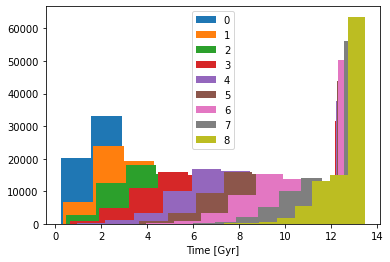

In [60]:
for i in range(9):
    plt.hist(percentiles[:,i],bins=10,label=str(i))
    #plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    print(np.max(percentiles[:,i]))
plt.legend()
plt.show()

We shuffle and save the indexes shuffled, or we just load them

In [61]:
#training with the first 90.000 elements of the dataset (previously shuffled) 

#index_sh=np.arange(100000)
#np.random.shuffle(index_sh)
#np.save('index_sh_1e5.npy',index_sh)
index_sh=np.load('./input/ind_sh_1e5.npy')

x=latents[index_sh[:90000],:]
theta=percentiles[index_sh[:90000],:]

We define the range for the posterior estimation (wrongly called prior) - all of them uniformly distributed between -2 and 16

In [62]:
lower_bounds = -2*torch.ones(np.shape(theta[0,:]))
upper_bounds = 18*torch.ones(np.shape(theta[0,:]))
bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

We define the model and train, then save the model

In [63]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train()
qphi = anpe.build_posterior(p_theta_x_est)

 Neural network successfully converged after 152 epochs.

Save posterior or load it

In [64]:
file="./my_posterior_1e5_m218_non_par.pkl"


with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()


"""file = open(file, 'rb')
qphi = pickle.load(file)
file.close()"""


"file = open(file, 'rb')\nqphi = pickle.load(file)\nfile.close()"

We create a function to see real vs predicted percentiles (we plot the mean and the interval of confidence: sigma, 2sigma... of the posteriors) for the test dataset (10.000 samples)

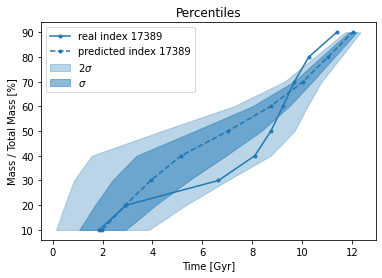

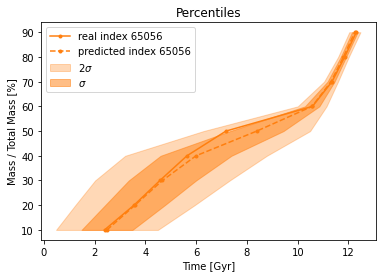

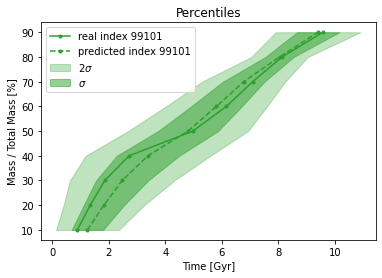

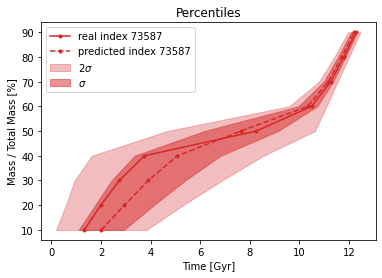

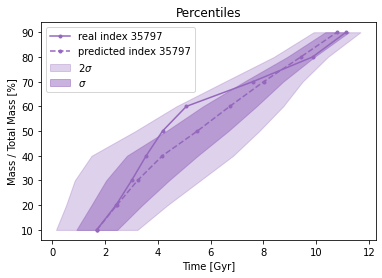

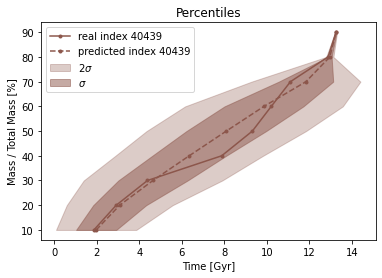

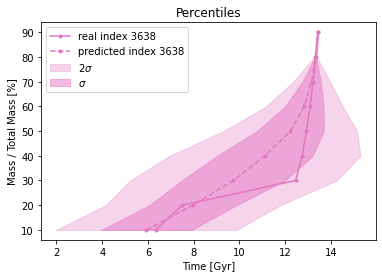

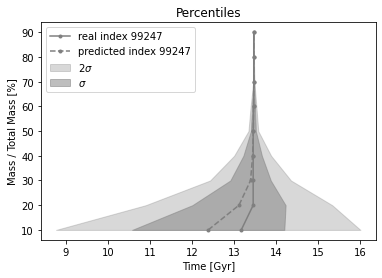

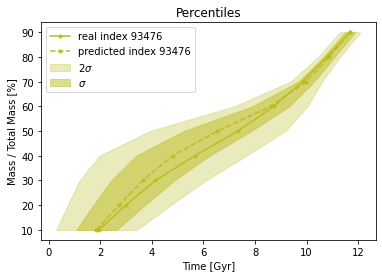

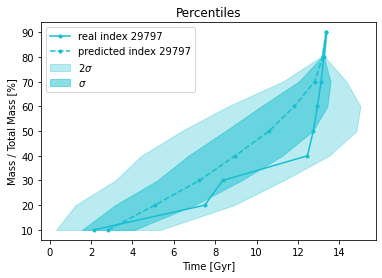

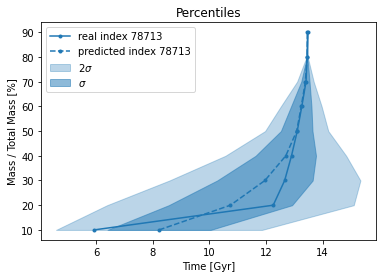

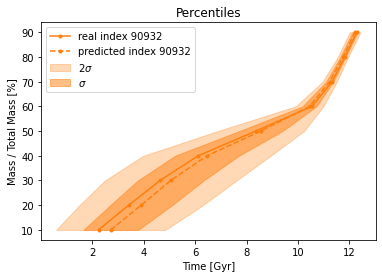

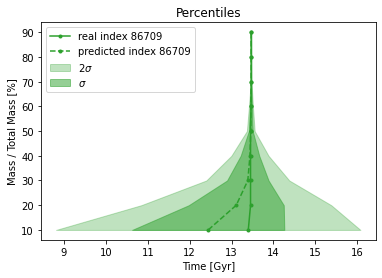

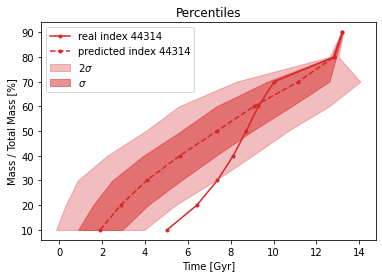

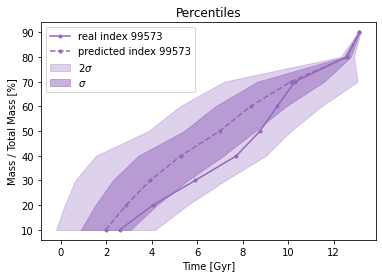

In [65]:
def plot_percentile_distribution(i,index_list=np.random.randint(90000,100000,15),mean=False,real_plot=False):
    
    if i==None:
        for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))
                
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='real index '+str(index_sh[j]))
                plt.plot(np.mean(posterior_samples,axis=0),np.arange(10,100,10),'.--',color='C'+str(k),label='predicted index '+str(index_sh[j]))
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+2*np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-2*np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                #plt.savefig('prediction_1e5_m216_'+str(k)+'.jpg')
                plt.show()

        
    else:
         for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,i-1],alpha=0.5,color='C'+str(k),label='index '+str(index_sh[j]))

                if mean:
                    plt.axvline(np.mean(posterior_samples[:,i-1]),ls='--',color='C'+str(k))
                    plt.axvline(percentiles[index_sh[j],i-1],ls='-',color='C'+str(k))
         
        
         plt.title('percentil posterior ' +str(i*10)+'%')
         #plt.legend()
         plt.xlabel('Time [Gyr]')
         plt.show()
            
         if real_plot:
            for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='index '+str(index_sh[j]))
            plt.title('Real percentiles')
            plt.xlabel('Time [Gyr]')
            plt.ylabel('Mass / Total Mass [%]')
            #plt.legend()
            plt.show()
    

    
#plot_percentile_distribution(1,mean=True)
#plot_percentile_distribution(5,mean=True)
#plot_percentile_distribution(9,mean=True,real_plot=True)
#index_sh=np.arange(1000)
#plot_percentile_distribution(None,index_list=np.random.randint(0,1000,15))
plot_percentile_distribution(None)

We plot the mean of the predicted posteriors (and save it after computed) vs the ground truth

In [66]:
n_evaluations=10000
n_samples=1000


index_list=np.arange(90000,100000)

stds=[]
means=[]

for k,j in tqdm(enumerate(index_list)):
    Xobs=latents[index_sh[j],:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))
    stds.append(np.std(posterior_samples,axis=0))
    means.append(np.mean(posterior_samples,axis=0))

np.save('means_1e5_m218_full_non_par.npy',means)
np.save('stds_1e5_m218_full_non_par.npy',stds)

10000it [56:08,  2.97it/s]


In [67]:
means=np.load('means_1e5_m218_full_non_par.npy')
stds=np.load('stds_1e5_m218_full_non_par.npy')

print(np.shape(means))
print(np.shape(stds))

(10000, 9)
(10000, 9)


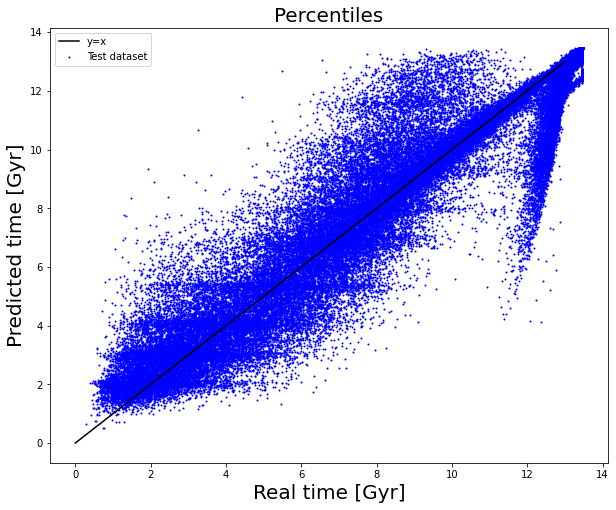

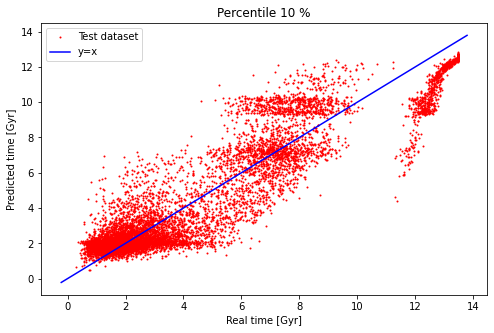

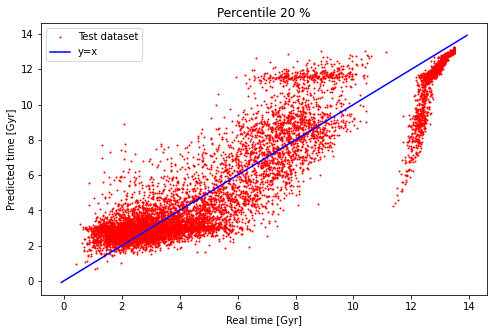

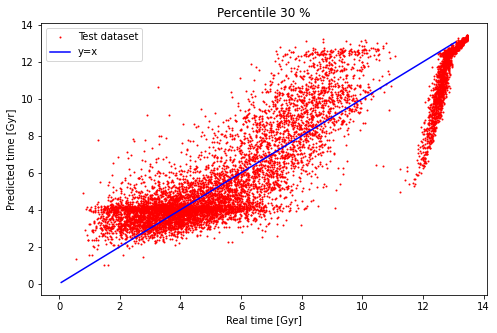

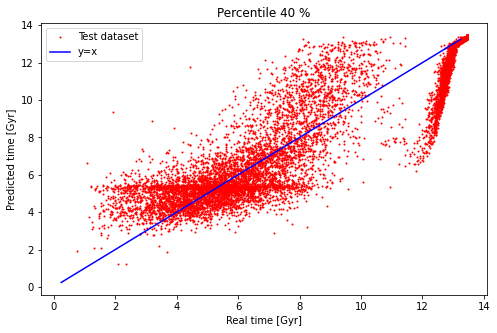

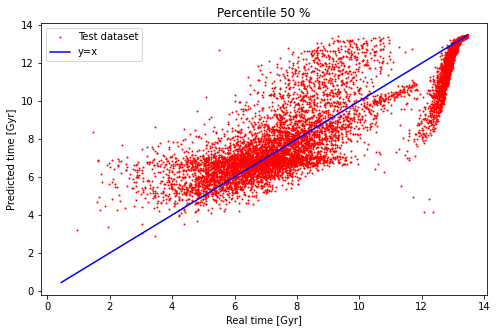

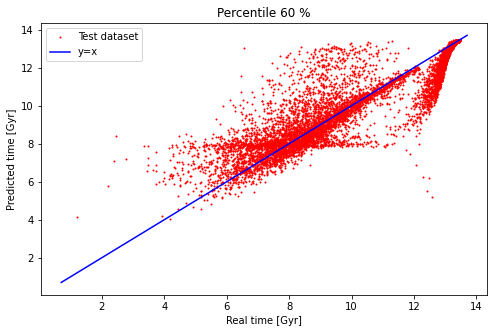

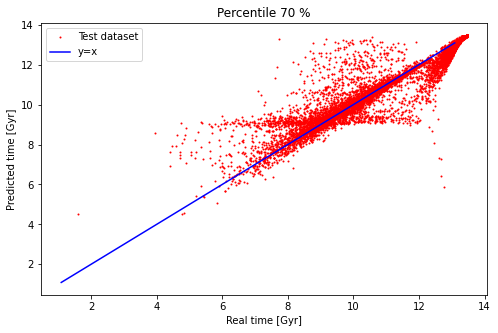

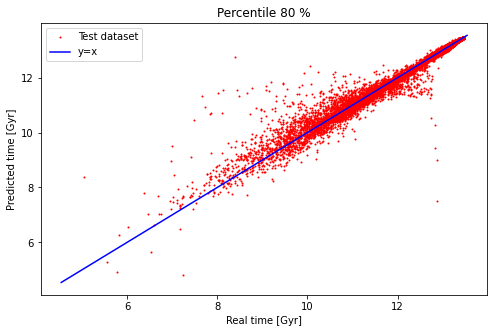

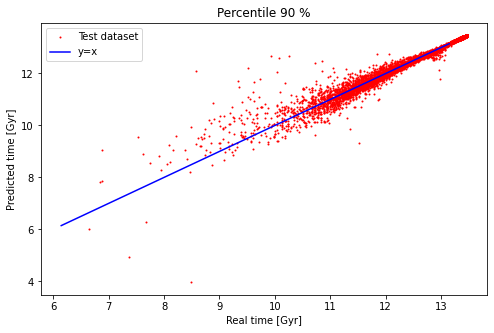

In [68]:
means=np.load('means_1e5_m218_full_non_par.npy')
stds=np.load('stds_1e5_m218_full_non_par.npy')

#all together
plt.figure(figsize=(10,8))

for i in range(9):
    if i==0:
        plt.plot(np.arange(14),np.arange(14),label='y=x',color='k')
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b',label='Test dataset')#,label=str((i+1)*10)+' %')
    else:
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b')#,label=str((i+1)*10)+' %')


        
plt.xlabel('Real time [Gyr]',fontsize=20)
plt.ylabel('Predicted time [Gyr]',fontsize=20)
plt.legend(fontsize=10)
plt.title('Percentiles',fontsize=20)
#plt.savefig('1e5_m216_pred_vs_true.jpg')
plt.show()

#one by one
for i in range(9):
    p=percentiles[index_sh[index_list],i]
    x=np.arange(np.min(p)-0.5,np.max(p)+0.5)
    plt.figure(figsize=(8,5))
    plt.scatter(p,means[:,i],s=1,color='r',label='Test dataset')
    plt.plot(x,x,label='y=x',color='b')
    plt.xlabel('Real time [Gyr]')
    plt.ylabel('Predicted time [Gyr]')
    plt.legend()
    plt.title('Percentile '+str((i+1)*10)+' %')
    #plt.savefig('1e5_m216_prediction'+str(i)+'.jpg')
    plt.show()

See how many values outside each interval of confidence (for at least one percentile or averaging )

In [71]:
#fraction of galaxies with at least 1 percentil with error outside the 1sigma interval

stds=np.array(stds)
means=np.array(means)
n_evaluations=10000

indexes=[]
for k,j in enumerate(index_list):
    #print('k:', k)
    for i in range(9):
        #print('i: ',i)
        if stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print('Fraction of galaxies with at least 1 percentil with error outside the 1sigma interval')
print(len(indexes)/n_evaluations * 100, '%')


      
#fraction of galaxies with at least 1 percentil with error outside the 2sigma interval

indexes=[]
for k,j in enumerate(index_list):
    for i in range(9):
        if 2*stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print('Fraction of galaxies with at least 1 percentil with error outside the 2sigma interval')
print(len(indexes)/n_evaluations * 100, '%')

#the same but averaged between all percentiles

#sigma
indexes=[]
for k,j in enumerate(index_list):
        if np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)

print('Fraction of galaxies with averaged error outside the averaged 1sigma interval')
print(len(indexes)/n_evaluations * 100, '%')

#2sigma
indexes=[]
for k,j in enumerate(index_list):
        if 2*np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)
            
print('Fraction of galaxies with averaged error outside the averaged 2sigma interval')
print(len(indexes)/n_evaluations * 100, '%')





Fraction of galaxies with at least 1 percentil with error outside the 1sigma interval
64.11 %
Fraction of galaxies with at least 1 percentil with error outside the 2sigma interval
18.279999999999998 %
Fraction of galaxies with averaged error outside the averaged 1sigma interval
21.060000000000002 %
Fraction of galaxies with averaged error outside the averaged 2sigma interval
1.59 %


Corner plot

0it [00:00, ?it/s]

index:  7124


1it [00:08,  8.12s/it]

index:  73029


2it [00:12,  6.01s/it]

index:  13772


3it [00:18,  5.74s/it]

index:  74586


4it [00:21,  4.90s/it]

index:  53119


5it [00:26,  5.21s/it]


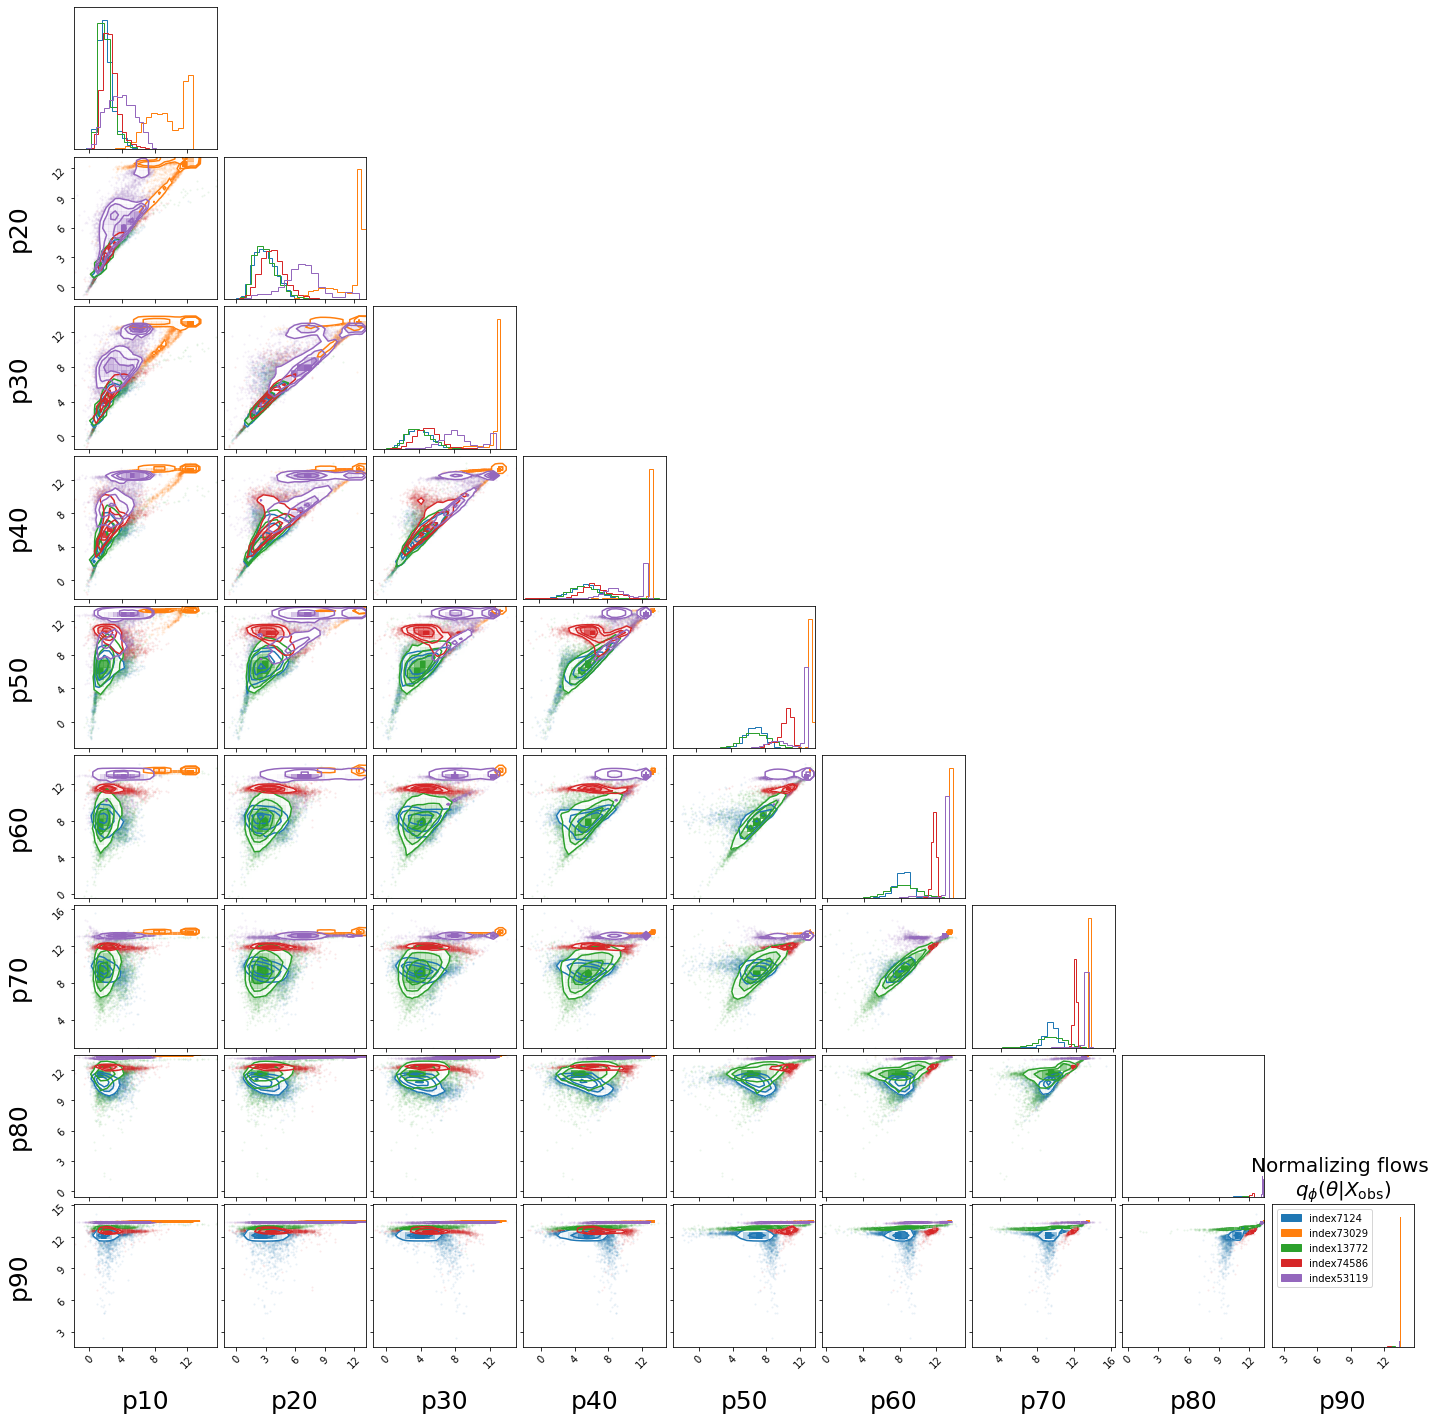

In [12]:
#all percentiles together

import corner

best_list=np.random.randint(90000,100000,5)

fig=plt.figure(figsize=(20,20))

posteriors=[]

for k,j in tqdm(enumerate(best_list)):
    print('index: ',index_sh[j])
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))
    posteriors.append(posterior_samples)
    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)] #label for percentiles

    #we plot all the percentiles
    _ = corner.corner(posterior_samples[:,:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
plt.legend(loc='upper left', fontsize=10)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$',fontsize=20)
plt.show()